In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
!pip install spanda

  Preparing metadata (setup.py) ... done
  Created wheel for brukeropusreader: filename=brukeropusreader-1.3.4-py3-none-any.whl size=5311 sha256=a052988ce8bdbd8f4570df41d72fbbc48936aaa95aca628f94b46d0a1a4a012d
  Stored in directory: /root/.cache/pip/wheels/6a/0d/86/91cddedf53ade4d06446f0efb197520a25ccc18b6725c65378
Successfully built brukeropusreader


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
                                    AnalytesTfm, SNVTfm, RandWAvgTfm, NormalizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
#device = torch.device('cuda:0' if use_cuda else 'cpu')
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

analyte_name = 725

In [ ]:
# Only samples with spectra
path = Path('/root/kssl-mirs-v2'); path.ls()

In [ ]:
# keep only when spectra in folder
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|██████████| 46305/46305 [00:01<00:00, 27034.24it/s]

n samples: 46251


In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
# Only strictly positive measurements
paths = [p for p in paths if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

n samples: 44565


In [ ]:
# Stats

## Spectra
#Xs = []
#n = 0
#for p in paths:
#    Xs.append(SpectraTfm()(get_target(p)))
#    n += 1 
#    if n > 1000: break
#print(f'X mean: {torch.mean(torch.concat(Xs))}, X Std: {torch.std(torch.concat(Xs))}');

In [ ]:
#ys = []
#n = 0
#for p in paths:
#    ys.append(AnalytesTfm(analytes=['K'])(get_target(p)))
#    n += 1 
#    if n > 1000: break

In [ ]:
#torch.concat(ys).min()

In [ ]:
#torch.concat(ys).max()

In [ ]:
#torch.concat(ys).mean()

In [ ]:
#import matplotlib.pyplot as plt

#plt.hist(torch.log10(torch.concat(ys)), bins=20)
#plt.xscale('log') 

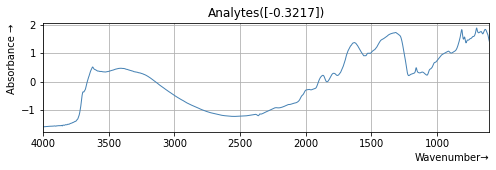

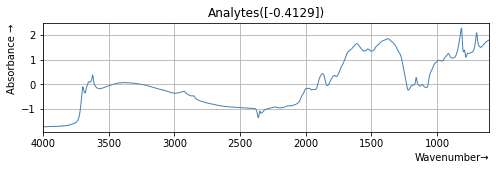

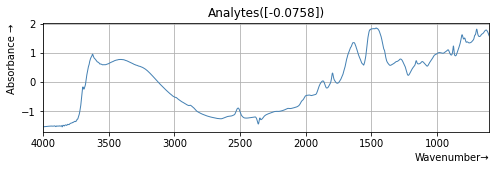

In [ ]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), SNVTfm(),
                              LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=3)
dls.show_batch()

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score()).to_fp16()

SuggestedLRs(valley=0.0005754399462603033)

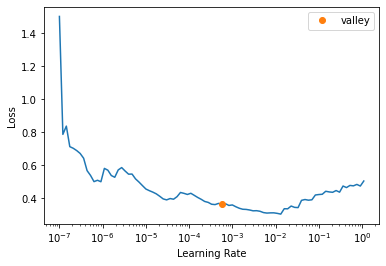

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.141457,0.123325,0.473447,06:59
1,0.121291,0.109823,0.531099,06:54
2,0.114840,0.124020,0.470482,06:55
3,0.098722,0.089686,0.617071,06:56
4,0.075183,0.081244,0.653119,06:58
5,0.069259,0.076557,0.673130,06:56
6,0.078079,0.074479,0.682002,06:56
7,0.056177,0.080317,0.657074,06:58
8,0.061138,0.069402,0.703681,07:00
9,0.061721,0.067104,0.713490,06:57


In [ ]:
learn.save('xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323')

Path('models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth')